# Custom metric

Keras makes working with neural networks, especially DNNs, very easy. The reason for this is the high level API. One of the things one can do is evaluate the learning process on custom metrics by extending the class `tf.keras.metrics.Metric`. In this notebook we will look at a custom metric that computes the confusion matrix and is capable of giving the recall, precision and f1 states.

While the ability to make custom metrics has been there for some time, tensorflow 2.2 has introduced model methods `train_step`, `test_step` and `predict_step` that are called by `model.fit` and `model.evaluate` etc. on a single batch. Now it is possible to call the `model.fit` method even for custom train steps (earlier this was done for the subclassing API as unbound functions that were not called by `model.fit`)


We will try this out on the Fashion MNIST dataset. We begin by standard imports.

In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Next we extend `tf.keras.metrics.Metric` to make a confusion matrix based metric. This object takes in true values and predictions (as probabilities) and updates a confusion matrix is maintains over an epoch. Internally, the fit method of the model calls this objects `update_state`. At the beginning of an epoch its method.

This object has to implement `reset_states` is called and in this case it sets all values to 0.

This object's `result` method returns the precision, recall and f1.

Finally, we have a method `fill_output` that takes in the output dict and updates its values. This dict is used by the model's `train_step` to fill in the results of training on a batch.


In [12]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            output['precision_{}'.format(i)]=results[0][i]
            output['recall_{}'.format(i)]=results[1][i]
            output['F1_{}'.format(i)]=results[2][i]
    


Next we override the `keras.Sequential` class to add the methods `train_step` and `test_step` so that the custom behavior required to handle the confusion matrix metric can be handled (this is because the custom metric does not return a single value but precisions, recalls and f1s for all classes).

In [13]:
class MySequential(keras.Sequential):
    
    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)
        return output
        
        
    def test_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        y_pred = self(x, training=False)  # Forward pass
        # Compute the loss value.
        # The loss function is configured in `compile()`.
        loss = self.compiled_loss(
            y,
            y_pred,
            regularization_losses=self.losses,
        )

        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)    
        return output
            


In [14]:
(x_train, y_train), (x_test, y_test)=keras.datasets.fashion_mnist.load_data()

In [15]:
model=MySequential([
    keras.layers.Input(shape=(28,28)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32,(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64,(3,3),activation='relu'),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

In [16]:
model.summary()

Model: "my_sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)      

In [17]:
loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=keras.optimizers.Adam()

In [18]:
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy',ConfusionMatrixMetric(10)])

In [19]:
es=keras.callbacks.EarlyStopping(patience=10)
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50, verbose=1, callbacks=[es])

Epoch 1/50
1875/1875 [==============================] - 16s 9ms/step - loss: 0.6300 - accuracy: 0.7818 - precision_0: 0.6258 - recall_0: 0.6817 - F1_0: 0.6523 - precision_1: 0.9197 - recall_1: 0.8889 - F1_1: 0.9025 - precision_2: 0.5617 - recall_2: 0.5491 - F1_2: 0.5540 - precision_3: 0.7053 - recall_3: 0.7500 - F1_3: 0.7264 - precision_4: 0.5527 - recall_4: 0.5854 - F1_4: 0.5684 - precision_5: 0.8116 - recall_5: 0.8328 - F1_5: 0.8212 - precision_6: 0.4118 - recall_6: 0.3252 - F1_6: 0.3620 - precision_7: 0.7838 - recall_7: 0.8203 - F1_7: 0.8016 - precision_8: 0.8778 - recall_8: 0.8340 - F1_8: 0.8548 - precision_9: 0.8619 - recall_9: 0.8935 - F1_9: 0.8770 - val_loss: 0.5597 - val_accuracy: 0.7955 - val_precision_0: 0.7335 - val_recall_0: 0.8120 - val_F1_0: 0.7708 - val_precision_1: 0.9558 - val_recall_1: 0.9510 - val_F1_1: 0.9534 - val_precision_2: 0.7217 - val_recall_2: 0.6510 - val_F1_2: 0.6845 - val_precision_3: 0.8753 - val_recall_3: 0.7580 - val_F1_3: 0.8124 - val_precision_4: 0.47

Epoch 7/50
1875/1875 [==============================] - 16s 8ms/step - loss: 0.3270 - accuracy: 0.8831 - precision_0: 0.8161 - recall_0: 0.8286 - F1_0: 0.8222 - precision_1: 0.9831 - recall_1: 0.9716 - F1_1: 0.9772 - precision_2: 0.8263 - recall_2: 0.8310 - F1_2: 0.8286 - precision_3: 0.8714 - recall_3: 0.8972 - F1_3: 0.8841 - precision_4: 0.7938 - recall_4: 0.8083 - F1_4: 0.8009 - precision_5: 0.9704 - recall_5: 0.9626 - F1_5: 0.9665 - precision_6: 0.7009 - recall_6: 0.6629 - F1_6: 0.6814 - precision_7: 0.9471 - recall_7: 0.9586 - F1_7: 0.9528 - precision_8: 0.9690 - recall_8: 0.9631 - F1_8: 0.9660 - precision_9: 0.9581 - recall_9: 0.9572 - F1_9: 0.9577 - val_loss: 0.3900 - val_accuracy: 0.8616 - val_precision_0: 0.7849 - val_recall_0: 0.8540 - val_F1_0: 0.8180 - val_precision_1: 0.9798 - val_recall_1: 0.9720 - val_F1_1: 0.9759 - val_precision_2: 0.9000 - val_recall_2: 0.6570 - val_F1_2: 0.7595 - val_precision_3: 0.9481 - val_recall_3: 0.7850 - val_F1_3: 0.8589 - val_precision_4: 0.68

Epoch 13/50
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2820 - accuracy: 0.8978 - precision_0: 0.8434 - recall_0: 0.8553 - F1_0: 0.8492 - precision_1: 0.9863 - recall_1: 0.9782 - F1_1: 0.9822 - precision_2: 0.8470 - recall_2: 0.8508 - F1_2: 0.8489 - precision_3: 0.8875 - recall_3: 0.9078 - F1_3: 0.8975 - precision_4: 0.8283 - recall_4: 0.8310 - F1_4: 0.8296 - precision_5: 0.9829 - recall_5: 0.9769 - F1_5: 0.9799 - precision_6: 0.7431 - recall_6: 0.7187 - F1_6: 0.7305 - precision_7: 0.9575 - recall_7: 0.9650 - F1_7: 0.9612 - precision_8: 0.9763 - recall_8: 0.9721 - F1_8: 0.9742 - precision_9: 0.9628 - recall_9: 0.9611 - F1_9: 0.9619 - val_loss: 0.3435 - val_accuracy: 0.8780 - val_precision_0: 0.7948 - val_recall_0: 0.8600 - val_F1_0: 0.8261 - val_precision_1: 0.9969 - val_recall_1: 0.9610 - val_F1_1: 0.9786 - val_precision_2: 0.8548 - val_recall_2: 0.7950 - val_F1_2: 0.8238 - val_precision_3: 0.8874 - val_recall_3: 0.8670 - val_F1_3: 0.8771 - val_precision_4: 0.7

Epoch 19/50
1875/1875 [==============================] - 18s 10ms/step - loss: 0.2529 - accuracy: 0.9094 - precision_0: 0.8554 - recall_0: 0.8651 - F1_0: 0.8602 - precision_1: 0.9903 - recall_1: 0.9793 - F1_1: 0.9847 - precision_2: 0.8580 - recall_2: 0.8561 - F1_2: 0.8569 - precision_3: 0.9010 - recall_3: 0.9213 - F1_3: 0.9110 - precision_4: 0.8379 - recall_4: 0.8348 - F1_4: 0.8363 - precision_5: 0.9880 - recall_5: 0.9822 - F1_5: 0.9851 - precision_6: 0.7585 - recall_6: 0.7463 - F1_6: 0.7522 - precision_7: 0.9611 - recall_7: 0.9708 - F1_7: 0.9659 - precision_8: 0.9825 - recall_8: 0.9823 - F1_8: 0.9824 - precision_9: 0.9722 - recall_9: 0.9686 - F1_9: 0.9704 - val_loss: 0.3342 - val_accuracy: 0.8844 - val_precision_0: 0.8756 - val_recall_0: 0.7390 - val_F1_0: 0.8015 - val_precision_1: 0.9928 - val_recall_1: 0.9630 - val_F1_1: 0.9777 - val_precision_2: 0.8323 - val_recall_2: 0.8040 - val_F1_2: 0.8179 - val_precision_3: 0.8371 - val_recall_3: 0.9250 - val_F1_3: 0.8789 - val_precision_4: 0.

Epoch 25/50
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2302 - accuracy: 0.9161 - precision_0: 0.8589 - recall_0: 0.8671 - F1_0: 0.8628 - precision_1: 0.9878 - recall_1: 0.9809 - F1_1: 0.9843 - precision_2: 0.8662 - recall_2: 0.8699 - F1_2: 0.8680 - precision_3: 0.9055 - recall_3: 0.9215 - F1_3: 0.9134 - precision_4: 0.8572 - recall_4: 0.8628 - F1_4: 0.8599 - precision_5: 0.9854 - recall_5: 0.9844 - F1_5: 0.9849 - precision_6: 0.7772 - recall_6: 0.7523 - F1_6: 0.7643 - precision_7: 0.9659 - recall_7: 0.9701 - F1_7: 0.9680 - precision_8: 0.9839 - recall_8: 0.9843 - F1_8: 0.9841 - precision_9: 0.9736 - recall_9: 0.9713 - F1_9: 0.9724 - val_loss: 0.3318 - val_accuracy: 0.8866 - val_precision_0: 0.8410 - val_recall_0: 0.8200 - val_F1_0: 0.8304 - val_precision_1: 0.9828 - val_recall_1: 0.9730 - val_F1_1: 0.9779 - val_precision_2: 0.7513 - val_recall_2: 0.8940 - val_F1_2: 0.8164 - val_precision_3: 0.9036 - val_recall_3: 0.8720 - val_F1_3: 0.8875 - val_precision_4: 0.8

In [20]:
history_dict=history.history

(0.0, 1.0)

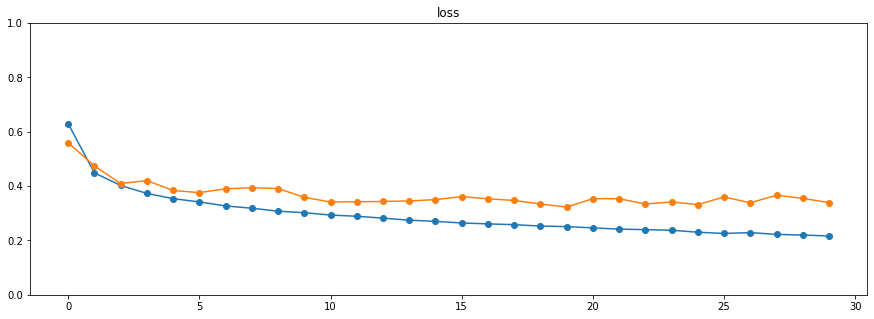

In [24]:
fig=plt.figure(figsize=(15,5))
plt.plot(history_dict['loss'],"-o")
plt.plot(history_dict['val_loss'],"-o")
plt.title('loss')
plt.ylim(0,1)

(0.0, 1.0)

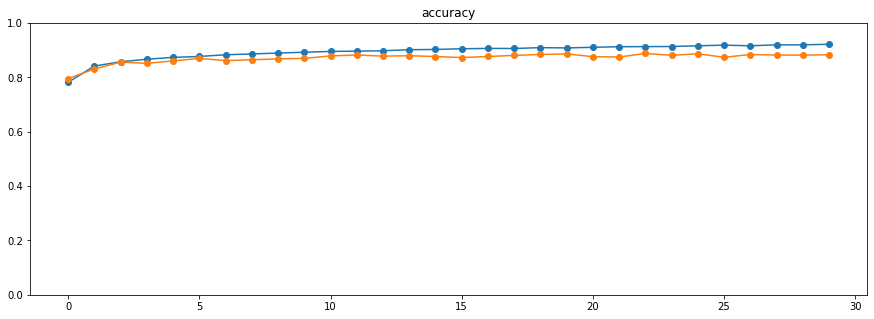

In [26]:
fig=plt.figure(figsize=(15,5))
plt.plot(history_dict['accuracy'],'-o')
plt.plot(history_dict['val_accuracy'],'-o')
plt.title('accuracy')
plt.ylim(0,1)

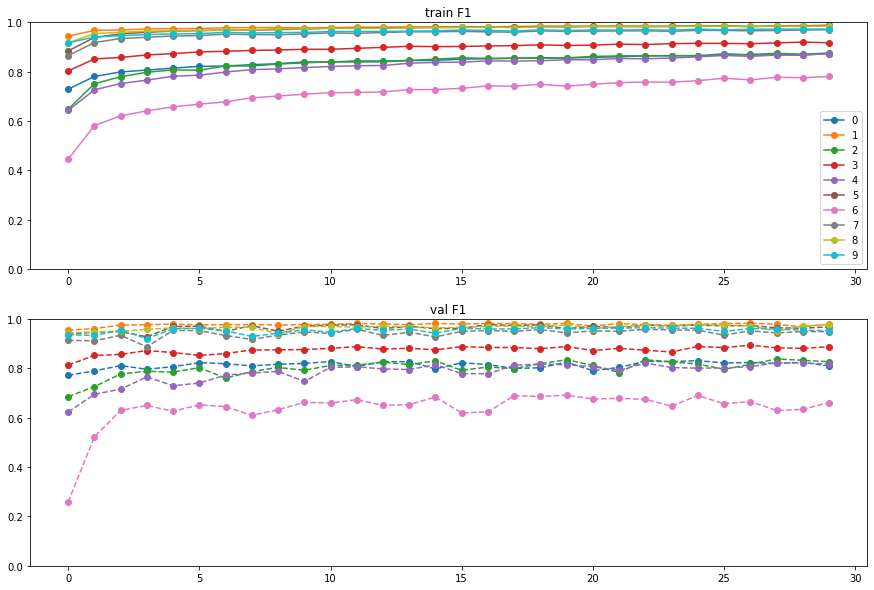

In [27]:
fig,axs=plt.subplots(2,1,figsize=(15,10))
for i in range(10):
    axs[0].plot(history_dict['F1_{}'.format(i)],'-o',label=i)
    axs[1].plot(history_dict['val_F1_{}'.format(i)],'--o',label=i)
axs[0].set_ylim(0,1)
axs[1].set_ylim(0,1)
    
axs[0].set_title('train F1')
axs[1].set_title('val F1')

axs[0].legend()

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

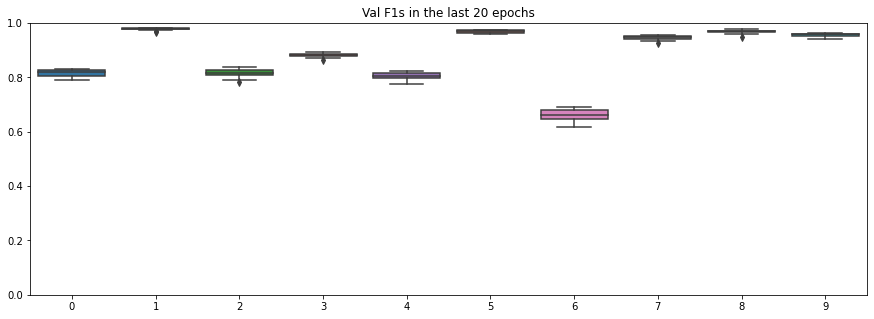

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({i:history_dict['val_F1_{}'.format(i)][-20:] for i in range(10)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.ylim(0,1)
plt.title('Val F1s in the last 20 epochs')

In [29]:

lbls=dict(map(lambda x: x.split('\t'),"""0 	T-shirt/top
1 	Trouser
2 	Pullover
3 	Dress
4 	Coat
5 	Sandal
6 	Shirt
7 	Sneaker
8 	Bag
9 	Ankle boot""".split('\n')))
lbls={int(k):v for k,v in lbls.items()}

In [30]:
lbls

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [36]:
y_pred=model(x_test)
y_pred_lbls=np.argmax(y_pred,-1)

In [32]:
cm=ConfusionMatrixMetric(10)
_=cm.update_state(y_test,y_pred)

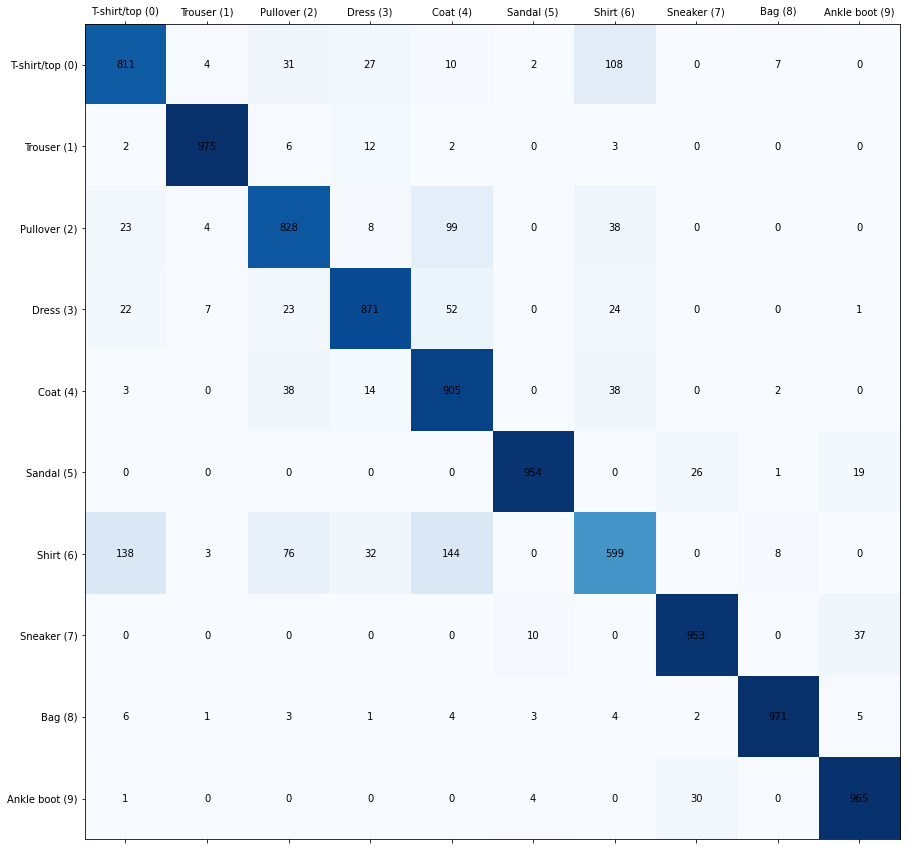

In [33]:
fig, ax = plt.subplots(figsize=(15,15))


cm_matrix = cm.total_cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(10):
    for j in range(10):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
plt.xticks(range(10),['{} ({})'.format(lbls[i],i) for i in range(10)])
plt.yticks(range(10),['{} ({})'.format(lbls[i],i) for i in range(10)])
plt.show()

In [34]:
def plot_confused(true_val,predicted_val):
    data=x_test[np.stack([y_test==true_val,y_pred_lbls==predicted_val],1).all(1)]
    idx=np.random.randint(len(data))
    print(idx)
    plt.imshow(data[idx])
    plt.title('{} confused for {}'.format(lbls[true_val],lbls[predicted_val]))

1


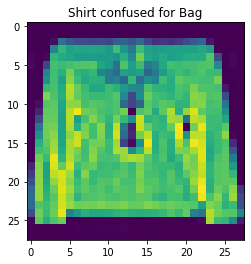

In [37]:
plot_confused(6,8)